In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.1 MB/s eta 0:00:00


In [2]:
from __future__ import print_function

import matplotlib
matplotlib.use('Agg')
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import random
from keras import backend as K
from scipy.io import savemat
from skimage.io import imsave
import nibabel as nib
# from data import load_data
# from net import unet
from tensorflow.python.keras import backend as K
from __future__ import print_function

from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.models import Model
from __future__ import print_function

import numpy as np
import os
import pandas as pd
from skimage.io import imread
from skimage.transform import rescale
from skimage.transform import rotate

import os
import pydicom
from PIL import Image
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:

batch_norm = False
smooth = 1.0


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def unet():
    inputs = Input((128, 128, 3))

    conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)

    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    if batch_norm:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    if batch_norm:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation('relu')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation('relu')(conv3)

    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    if batch_norm:
        conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Activation('relu')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation('relu')(conv4)

    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    if batch_norm:
        conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Activation('relu')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    if batch_norm:
        conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Activation('relu')(conv5)

    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    if batch_norm:
        conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Activation('relu')(conv5)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)

    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    if batch_norm:
        conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Activation('relu')(conv6)

    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    if batch_norm:
        conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    if batch_norm:
        conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Activation('relu')(conv7)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    if batch_norm:
        conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)

    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    if batch_norm:
        conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Activation('relu')(conv8)

    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    if batch_norm:
        conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)

    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    if batch_norm:
        conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Activation('relu')(conv9)

    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    if batch_norm:
        conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Activation('relu')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


In [67]:
# Function to get the slice location from a DICOM file
def get_slice_location(dicom_data):
    # dicom_data = pydicom.dcmread(dicom_path)
    slice_location_tag = (0x0020, 0x1041)
    try:
        return dicom_data[slice_location_tag].value
    except KeyError:
        return None

def dicom_to_tiff(input_dicom_paths_1,input_dicom_paths_2,input_dicom_paths_3):
    all_pil = []
    all_pil2 = []
    all_pil3 = []

    for image_path_1,_ in input_dicom_paths_1.items():

        # Read the DICOM file
        if '.dcm' in image_path_1:

            dicom_image = pydicom.dcmread(image_path_1,force=True)

            # Get the pixel array from the DICOM file
            image_array = dicom_image.pixel_array

            image = Image.fromarray(image_array)
            image = image.convert('L')
            resized_image = image.resize((128,128), Image.ANTIALIAS)
            image_array = np.array(resized_image)

            # Normalize the image array to the range 0-255 (8-bit)
            image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
            image_array = image_array.astype(np.uint8)

            # Convert the numpy array to a PIL Image
            pil_image = Image.fromarray(image_array)
            # pil_image = pil_image.convert(mode='RGB')
            display(pil_image)

            all_pil.append(pil_image)

    for image_path_2,_ in input_dicom_paths_1.items():


        # Read the DICOM file
        if '.dcm' in image_path_2:

            dicom_image2 = pydicom.dcmread(image_path_2,force=True)

            # Get the pixel array from the DICOM file
            image_array2 = dicom_image2.pixel_array

            image2 = Image.fromarray(image_array2)
            image2 = image2.convert('L')
            resized_image2 = image2.resize((128,128), Image.ANTIALIAS)
            image_array2 = np.array(resized_image2)

            # Normalize the image array to the range 0-255 (8-bit)
            image_array2 = (image_array2 - np.min(image_array2)) / (np.max(image_array2) - np.min(image_array2)) * 255
            image_array2 = image_array2.astype(np.uint8)

            # Convert the numpy array to a PIL Image
            pil_image2 = Image.fromarray(image_array2)
            # pil_image2 = pil_image2.convert(mode='RGB')
            display(pil_image2)

            all_pil2.append(pil_image2)

    for image_path_3,_ in input_dicom_paths_3.items():

        # Read the DICOM file
        if '.dcm' in image_path_3:

            dicom_image3 = pydicom.dcmread(image_path_3,force=True)

            # Get the pixel array from the DICOM file
            image_array3 = dicom_image3.pixel_array

            image3 = Image.fromarray(image_array3)
            image3 = image3.convert('L')
            resized_image3 = image3.resize((128,128), Image.ANTIALIAS)
            image_array3 = np.array(resized_image3)

            # Normalize the image array to the range 0-255 (8-bit)
            image_array3 = (image_array3 - np.min(image_array3)) / (np.max(image_array3) - np.min(image_array3)) * 255
            image_array3 = image_array3.astype(np.uint8)

            # Convert the numpy array to a PIL Image
            pil_image3 = Image.fromarray(image_array3)
            display(pil_image3)
            # pil_image3 = pil_image3.convert(mode='RGB')

            all_pil3.append(pil_image3)
    return all_pil,all_pil2,all_pil3


def load_data(paths_1,paths_2,paths_3):

    images_list_1 = glob.glob(test_images_path+paths_1+"/*.dcm")
    images_list_2 = glob.glob(test_images_path+paths_2+"/*.dcm")
    images_list_3 = glob.glob(test_images_path+paths_3+"/*.dcm")

    imagee_li_1 = []
    slicee_li_1 = []
    imagee_li_2 = []
    slicee_li_2 = []
    imagee_li_3 = []
    slicee_li_3 = []
    print(len(images_list_3))

    for imgeee_1 in images_list_1:
      dicom_image_1 = pydicom.dcmread(imgeee_1,force=True)
      slice_num_1 = get_slice_location(dicom_image_1)
      imagee_li_1.append(imgeee_1)
      slicee_li_1.append(slice_num_1)

    for imgeee_2 in images_list_2:
      dicom_image_2 = pydicom.dcmread(imgeee_2,force=True)
      slice_num_2 = get_slice_location(dicom_image_2)
      imagee_li_2.append(imgeee_2)
      slicee_li_2.append(slice_num_2)

    for imgeee_3 in images_list_3:
      dicom_image_3 = pydicom.dcmread(imgeee_3,force=True)
      slice_num_3 = get_slice_location(dicom_image_3)
      imagee_li_3.append(imgeee_3)
      slicee_li_3.append(slice_num_3)

    sorting_dict_1 = dict(zip(imagee_li_1,slicee_li_1))
    sorteds_1 = dict(sorted(sorting_dict_1.items(), key=lambda item: item[1]))

    sorting_dict_2 = dict(zip(imagee_li_2,slicee_li_2))
    sorteds_2 = dict(sorted(sorting_dict_2.items(), key=lambda item: item[1]))

    sorting_dict_3 = dict(zip(imagee_li_3,slicee_li_3))
    sorteds_3 = dict(sorted(sorting_dict_3.items(), key=lambda item: item[1]))



    tiff_files,tiff_files2,tiff_files3 = dicom_to_tiff(sorteds_1,sorteds_2,sorteds_3)
    total_count = len(tiff_files)

    images = np.ndarray((total_count, 128, 128,3), dtype=np.uint8)

    for i in range(len(tiff_files)):

        img = np.dstack((tiff_files[i], tiff_files2[i], tiff_files3[i]))
        img = np.array(img)
        images[i] = img

    return images


In [60]:
# from tensorflow.keras import backend as K
weights_path = '/content/drive/MyDrive/IAAA-Challenge/Segmentation/weights_128.h5'

def predict(patient_path_1,patient_path_2,patient_path_3,patno):

    print(patient_path_1)
    print(patient_path_2)
    print(patient_path_3)

    predictions_path = '/content/drive/MyDrive/IAAA-Challenge/Segmentation/results/'+str(patno)

    imgs_test = load_data(patient_path_1,patient_path_2,patient_path_3)

    original_imgs_test = imgs_test.astype(np.uint8)

    # load model with weights
    model = unet()
    model.load_weights(weights_path)

    # make predictions
    imgs_mask_pred = model.predict(imgs_test, verbose=1)

    # save to mat file for further processing
    if not os.path.exists(predictions_path):
        os.mkdir(predictions_path)

    matdict = {
        'pred': imgs_mask_pred,
        'image': original_imgs_test,
    }
    # savemat(os.path.join(predictions_path, 'predictions.mat'), matdict)
    slices = []
    # save images with segmentation and ground truth mask overlay
    for i in range(len(imgs_test)):
        pred = imgs_mask_pred[i]
        image = original_imgs_test[i]

        # segmentation mask is for the middle slice
        image_rgb = gray2rgb(image[:, :, 1])

        # prediction contour image
        pred = (np.round(pred[:, :, 0]) * 255.0).astype(np.uint8)
        contours,hed= cv2.findContours(pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        kernel = np.ones((9,9), np.uint8)

        mask = cv2.morphologyEx(pred, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(pred, cv2.MORPH_OPEN, kernel)

        # put mask into alpha channel of result
        result = image_rgb.copy()
        result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
        result[:, :, 3] = mask

        pred = np.zeros(np.array(pred).shape)
        cv2.drawContours(image_rgb, contours,-1, (255, 50, 50), 1)

        img_gray = 0 - result[:, :, 3]
        grayscale = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]

        slices.append(grayscale*img_gray)

    nifti = dicom_to_3d_array(slices)
    save_nifti(nifti,predictions_path+".nii.gz")

# Function to convert DICOM slices to a 3D numpy array
def dicom_to_3d_array(slices):
    image_3d = np.zeros([128,128,len(slices)], dtype=float)
    for i,slice in enumerate(slices):
        image_3d[:, :, i] = slice
    return image_3d

# Function to save a numpy array as a NIfTI file
def save_nifti(image_3d, output_path):
    nifti_image = nib.Nifti1Image(image_3d, np.eye(4))
    nib.save(nifti_image, output_path)

def gray2rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = im
    return ret

10733
10733
10733
1.3.46.670589.11.10042.5.0.6596.2024022114520585576
1.3.46.670589.11.10042.5.0.6596.2024022114530132577
1.3.46.670589.11.10042.5.0.6596.2024022114542546608
16


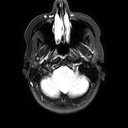

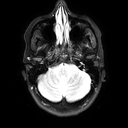

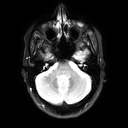

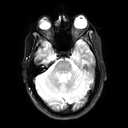

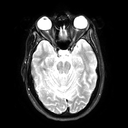

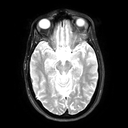

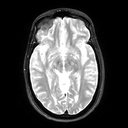

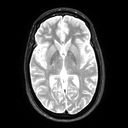

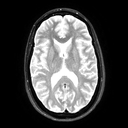

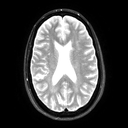

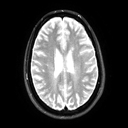

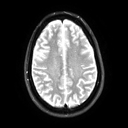

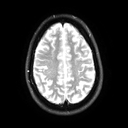

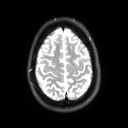

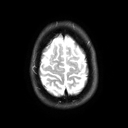

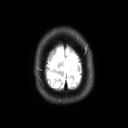

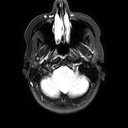

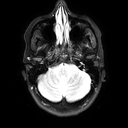

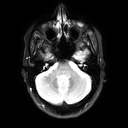

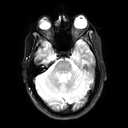

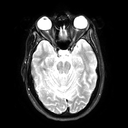

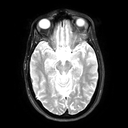

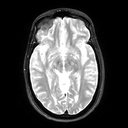

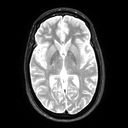

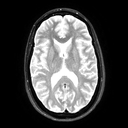

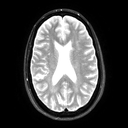

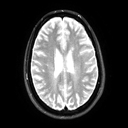

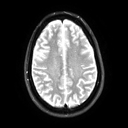

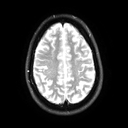

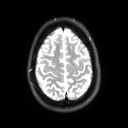

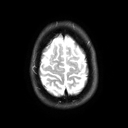

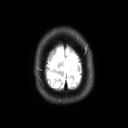

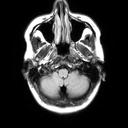

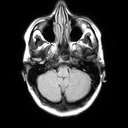

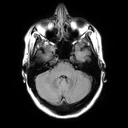

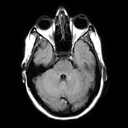

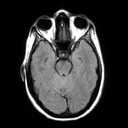

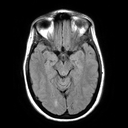

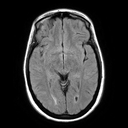

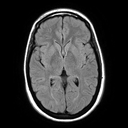

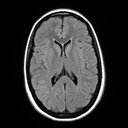

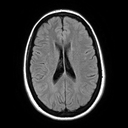

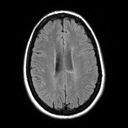

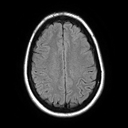

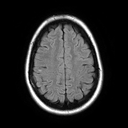

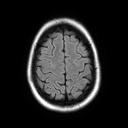

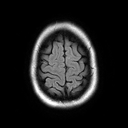

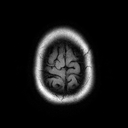

1/1 [==============================] - 2s 2s/step
15079
15079
15079
1.3.46.670589.11.10042.5.0.4960.2023123102394671164
1.3.46.670589.11.10042.5.0.4960.2023123102403223165
1.3.46.670589.11.10042.5.0.4960.2023123102415306198
16


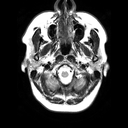

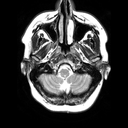

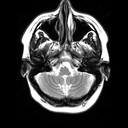

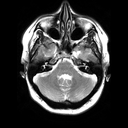

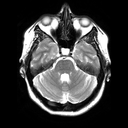

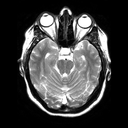

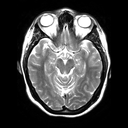

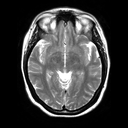

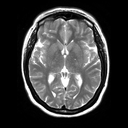

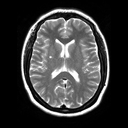

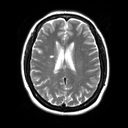

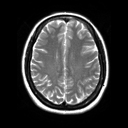

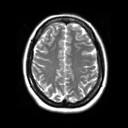

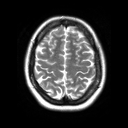

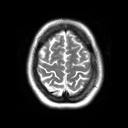

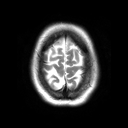

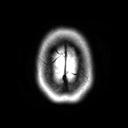

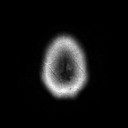

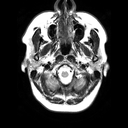

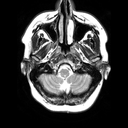

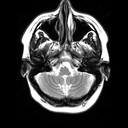

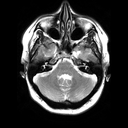

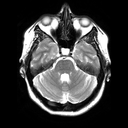

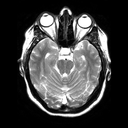

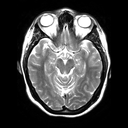

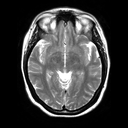

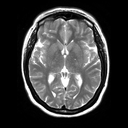

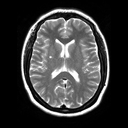

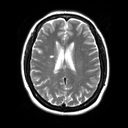

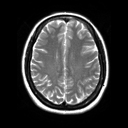

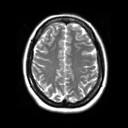

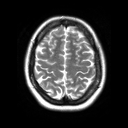

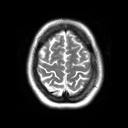

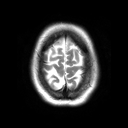

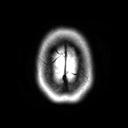

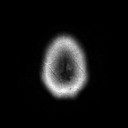

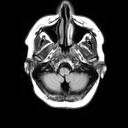

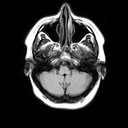

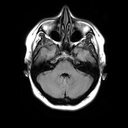

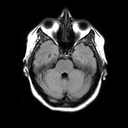

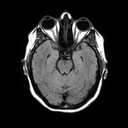

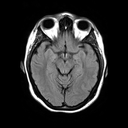

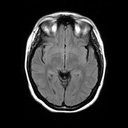

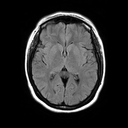

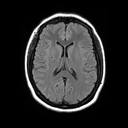

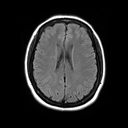

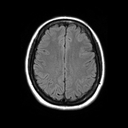

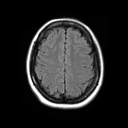

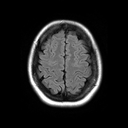

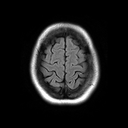

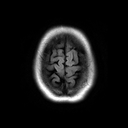

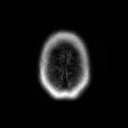

IndexError: list index out of range

In [68]:
test_images_path = '/content/drive/MyDrive/IAAA-Challenge/data/'
import glob
sd_tag = (0x0008,0x103E)
all_from_meta = pd.read_csv("/content/drive/MyDrive/IAAA-Challenge/meta.csv")

i =0
while i < all_from_meta.shape[0]:

  pats_1 = all_from_meta.iloc[i,2]
  print(all_from_meta.iloc[i,0])
  print(all_from_meta.iloc[i+1,0])
  print(all_from_meta.iloc[i+2,0])

  pats_2 = all_from_meta.iloc[i+1,2]
  pats_3 = all_from_meta.iloc[i+2,2]
  i =i+3

  predict(pats_1,pats_2,pats_3,all_from_meta.iloc[i,0])